# Classification problem using the Clean California Housing Prices dataset

The problem consists of estimating the approximate location of housing blocks. The approximate location is called ocean_proximity which may have one of four possible values: NEAR BAY, 1H OCEAN, INLAND, and NEAR OCEAN.
    
The features variables arabe prepocessed and normalised in range between [-1,1]. The target variable is oneHote encoded and the all dataset is shuffled and divided in three set: trainset, validset and testset. 

The architecture of the deep artificial neural network and some hyperparameters are tuned using Hyperas. Hyperas is a convenient when try to hupertune Keras models. it's a wrapper of the famous optimisation packge hyperopt.



Please Note to ensure compatibility of hyperas with hyperopt==0.2.7, modify the line 139 in optim.py in hyperas, from rstate=np.random.RandomState(rseed) to rstate=np.random.default_rng(rseed).


In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, 

In [13]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [3]:
import tensorflow as tf
import sys

In [4]:
## limit the use of GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## I- Prepare the data

In [ ]:
# import data in a datframe
df = pd.read_csv("./California_Housing_Prices_Clean.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20428 entries, 0 to 20427
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20428 non-null  float64
 1   latitude            20428 non-null  float64
 2   housing_median_age  20428 non-null  float64
 3   total_rooms         20428 non-null  float64
 4   total_bedrooms      20428 non-null  float64
 5   population          20428 non-null  float64
 6   households          20428 non-null  float64
 7   median_income       20428 non-null  float64
 8   median_house_value  20428 non-null  float64
 9   ocean_proximity     20428 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
# ocean_proximity is the target
df['ocean_proximity'].unique()

array(['NEAR OCEAN', 'NEAR BAY', 'INLAND', '<1H OCEAN'], dtype=object)

In [8]:
# Shuffle and split the data
df = df.reindex(np.random.permutation(df.index)) 
mask_0 = np.random.rand(len(df)) < 0.8

trainDF = pd.DataFrame(df[mask_0])
validationDF_0 = pd.DataFrame(df[~mask_0])

mask_1 = np.random.rand(len(validationDF_0)) < 0.5
validationDF = pd.DataFrame(validationDF_0[mask_1])
testDF = pd.DataFrame(validationDF_0[~mask_1])

print(f"Training DF: {len(trainDF)}")
print(f"Training DF portion: {len(trainDF)/len(df)}")
print("----------------------------------")
print(f"Validation DF: {len(validationDF)}")
print(f"Validation DF portion: {len(validationDF)/len(df)}")
print("----------------------------------")
print(f"Test DF: {len(testDF)}")
print(f"Test DF portion: {len(testDF)/len(df)}")

Training DF: 16191
Training DF portion: 0.7925886038770316
----------------------------------
Validation DF: 2042
Validation DF portion: 0.09996083806540043
----------------------------------
Test DF: 2195
Test DF portion: 0.10745055805756805


In [9]:
## oneHote code the target
X_train = trainDF.drop('ocean_proximity',axis=1).values
y_train = trainDF['ocean_proximity'].values
y_train = pd.get_dummies(y_train).astype('float32').values 

X_val   = validationDF.drop('ocean_proximity',axis=1).values
y_val   = validationDF['ocean_proximity'].values
y_val = pd.get_dummies(y_val).astype('float32').values 

X_test  = testDF.drop('ocean_proximity',axis=1).values
y_test  = testDF['ocean_proximity'].values
y_test  = pd.get_dummies(y_test ).astype('float32').values 

In [10]:
### the function data is for Hyperas
def data():
    df = pd.read_csv("./California_Housing_Prices_Clean.csv")
    # Usually a good idea to shuffle
    df = df.reindex(np.random.permutation(df.index)) 
    mask_0 = np.random.rand(len(df)) < 0.8

    trainDF = pd.DataFrame(df[mask_0])
    validationDF_0 = pd.DataFrame(df[~mask_0])

    mask_1 = np.random.rand(len(validationDF_0)) < 0.5
    validationDF = pd.DataFrame(validationDF_0[mask_1])

    
    X_train = trainDF.drop('ocean_proximity',axis=1).values
    y_train = trainDF['ocean_proximity'].values
    y_train = pd.get_dummies(y_train).astype('float32').values 

    X_val   = validationDF.drop('ocean_proximity',axis=1).values
    y_val   = validationDF['ocean_proximity'].values
    y_val = pd.get_dummies(y_val).astype('float32').values 



    return X_train, y_train, X_val, y_val

## II- Build the model with Hyperparameters

In [23]:
#the model function is for Hyperas
def model(X_train, y_train, X_val, y_val):
    
    model = Sequential()
    model.add(Dense({{choice([8,16,32,64,128, 256, 512, 1024])}}, input_shape=(X_train.shape[1],), activation='relu'))
    #model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense({{choice([8,16,32,64,128, 256, 512, 1024])}},activation='relu' ))
    #model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    if {{choice(['two', 'three'])}} == 'three':
        model.add(Dense({{choice([8,16,32,64,128, 256, 512, 1024])}},activation='relu'))
        #model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))
        
    model.add(Dense(y_train.shape[1]))
    model.add(Activation('softmax'))
    
    optim = Adam(learning_rate={{choice([10**-4,10**-3, 10**-2, 10**-1])}})
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    model.fit(X_train, y_train,
              batch_size={{choice([16,32,64])}},
              epochs=40,
              verbose=2,
              validation_data=(X_val, y_val))
    score, acc = model.evaluate(X_val, y_val, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

## III- Tune Hyperparameter's of the model

In [24]:
## Run the otimization
### please note that the notebook_name is the same as your actual notebook

clear_session()
X_train, y_train, X_val, y_val = data()
with Timer(name="context manager"):
    
    best_run, best_model = optim.minimize(model=model,
                                      data=data,
                                      algo=tpe.suggest,
                                      #rstate=np.random.RandomState(42),
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='Classification_California_Housing_Prices')

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Activation, Input, Dropout
except:
    pass

try:
    from tensorflow.keras.callbacks import EarlyStopping
except:
    pass

try:
    from tensorflow.keras.optimizers import SGD
except:
    pass

try:
    from tensorflow.keras.backend import clear_session
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from tensorflow.keras.optimizers import Adam
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import tensorflow as tf
except:
    pass

510/510 - 2s - loss: 0.2604 - accuracy: 0.8921 - val_loss: 0.2167 - val_accuracy: 0.9190 - 2s/epoch - 4ms/step                                                                    

Epoch 35/40                                                                                                                                                                       

510/510 - 2s - loss: 0.2547 - accuracy: 0.8976 - val_loss: 0.2178 - val_accuracy: 0.9113 - 2s/epoch - 4ms/step                                                                    

Epoch 36/40                                                                                                                                                                       

510/510 - 2s - loss: 0.2511 - accuracy: 0.8974 - val_loss: 0.2132 - val_accuracy: 0.9185 - 2s/epoch - 4ms/step                                                                    

Epoch 37/40                                                                                         

1020/1020 - 4s - loss: 1.2352 - accuracy: 0.4421 - val_loss: 1.2187 - val_accuracy: 0.4544 - 4s/epoch - 4ms/step                                                                  

Epoch 39/40                                                                                                                                                                       

1020/1020 - 4s - loss: 1.2343 - accuracy: 0.4421 - val_loss: 1.2188 - val_accuracy: 0.4544 - 4s/epoch - 4ms/step                                                                  

Epoch 40/40                                                                                                                                                                       

1020/1020 - 4s - loss: 1.2343 - accuracy: 0.4421 - val_loss: 1.2218 - val_accuracy: 0.4544 - 4s/epoch - 4ms/step                                                                  

Test accuracy:                                                                                      

510/510 - 3s - loss: 0.7175 - accuracy: 0.7252 - val_loss: 0.5176 - val_accuracy: 0.7881 - 3s/epoch - 6ms/step                                                                    

Epoch 2/40                                                                                                                                                                        

510/510 - 2s - loss: 0.5382 - accuracy: 0.7793 - val_loss: 0.4177 - val_accuracy: 0.8172 - 2s/epoch - 4ms/step                                                                    

Epoch 3/40                                                                                                                                                                        

510/510 - 2s - loss: 0.4985 - accuracy: 0.7960 - val_loss: 0.3688 - val_accuracy: 0.8429 - 2s/epoch - 4ms/step                                                                    

Epoch 4/40                                                                                          

1020/1020 - 5s - loss: 0.4594 - accuracy: 0.8183 - val_loss: 0.3481 - val_accuracy: 0.8516 - 5s/epoch - 5ms/step                                                                  

Epoch 6/40                                                                                                                                                                        

1020/1020 - 5s - loss: 0.4449 - accuracy: 0.8216 - val_loss: 0.3293 - val_accuracy: 0.8550 - 5s/epoch - 5ms/step                                                                  

Epoch 7/40                                                                                                                                                                        

1020/1020 - 4s - loss: 0.4225 - accuracy: 0.8329 - val_loss: 0.3311 - val_accuracy: 0.8608 - 4s/epoch - 4ms/step                                                                  

Epoch 8/40                                                                                          

255/255 - 1s - loss: 0.2611 - accuracy: 0.8940 - val_loss: 0.2058 - val_accuracy: 0.9132 - 1s/epoch - 4ms/step                                                                    

Epoch 10/40                                                                                                                                                                       

255/255 - 1s - loss: 0.2533 - accuracy: 0.8948 - val_loss: 0.2393 - val_accuracy: 0.9011 - 1s/epoch - 4ms/step                                                                    

Epoch 11/40                                                                                                                                                                       

255/255 - 1s - loss: 0.2408 - accuracy: 0.9016 - val_loss: 0.2672 - val_accuracy: 0.8841 - 1s/epoch - 4ms/step                                                                    

Epoch 12/40                                                                                         

510/510 - 2s - loss: 1.1603 - accuracy: 0.4475 - val_loss: 1.1559 - val_accuracy: 0.4544 - 2s/epoch - 4ms/step                                                                    

Epoch 14/40                                                                                                                                                                       

510/510 - 2s - loss: 1.1541 - accuracy: 0.4477 - val_loss: 1.1386 - val_accuracy: 0.4040 - 2s/epoch - 4ms/step                                                                    

Epoch 15/40                                                                                                                                                                       

510/510 - 2s - loss: 1.1463 - accuracy: 0.4500 - val_loss: 1.1221 - val_accuracy: 0.3986 - 2s/epoch - 4ms/step                                                                    

Epoch 16/40                                                                                         

510/510 - 2s - loss: 0.7403 - accuracy: 0.7162 - val_loss: 0.6273 - val_accuracy: 0.7706 - 2s/epoch - 4ms/step                                                                    

Epoch 18/40                                                                                                                                                                       

510/510 - 2s - loss: 0.7317 - accuracy: 0.7168 - val_loss: 0.6224 - val_accuracy: 0.7755 - 2s/epoch - 4ms/step                                                                    

Epoch 19/40                                                                                                                                                                       

510/510 - 2s - loss: 0.7241 - accuracy: 0.7200 - val_loss: 0.6164 - val_accuracy: 0.7774 - 2s/epoch - 4ms/step                                                                    

Epoch 20/40                                                                                         

510/510 - 3s - loss: 0.6585 - accuracy: 0.7327 - val_loss: 0.5350 - val_accuracy: 0.8206 - 3s/epoch - 5ms/step                                                                    

Epoch 22/40                                                                                                                                                                       

510/510 - 3s - loss: 0.6538 - accuracy: 0.7310 - val_loss: 0.5210 - val_accuracy: 0.8143 - 3s/epoch - 5ms/step                                                                    

Epoch 23/40                                                                                                                                                                       

510/510 - 2s - loss: 0.6556 - accuracy: 0.7295 - val_loss: 0.5111 - val_accuracy: 0.8186 - 2s/epoch - 5ms/step                                                                    

Epoch 24/40                                                                                         

255/255 - 1s - loss: 0.4874 - accuracy: 0.8055 - val_loss: 0.4090 - val_accuracy: 0.8371 - 1s/epoch - 6ms/step                                                                    

Epoch 26/40                                                                                                                                                                       

255/255 - 2s - loss: 0.4714 - accuracy: 0.8118 - val_loss: 0.4004 - val_accuracy: 0.8443 - 2s/epoch - 6ms/step                                                                    

Epoch 27/40                                                                                                                                                                       

255/255 - 1s - loss: 0.4738 - accuracy: 0.8102 - val_loss: 0.3914 - val_accuracy: 0.8463 - 1s/epoch - 6ms/step                                                                    

Epoch 28/40                                                                                         

510/510 - 2s - loss: 1.7984 - accuracy: 0.4367 - val_loss: 1.2189 - val_accuracy: 0.4544 - 2s/epoch - 5ms/step                                                                    

Epoch 30/40                                                                                                                                                                       

510/510 - 2s - loss: 1.2404 - accuracy: 0.4359 - val_loss: 1.2173 - val_accuracy: 0.4544 - 2s/epoch - 5ms/step                                                                    

Epoch 31/40                                                                                                                                                                       

510/510 - 2s - loss: 1.2392 - accuracy: 0.4383 - val_loss: 1.2344 - val_accuracy: 0.4544 - 2s/epoch - 5ms/step                                                                    

Epoch 32/40                                                                                         

255/255 - 1s - loss: 0.4587 - accuracy: 0.8297 - val_loss: 0.3978 - val_accuracy: 0.8249 - 1s/epoch - 6ms/step                                                                    

Epoch 34/40                                                                                                                                                                       

255/255 - 1s - loss: 0.5019 - accuracy: 0.8140 - val_loss: 0.4718 - val_accuracy: 0.8196 - 1s/epoch - 6ms/step                                                                    

Epoch 35/40                                                                                                                                                                       

255/255 - 1s - loss: 0.4664 - accuracy: 0.8247 - val_loss: 0.4124 - val_accuracy: 0.8196 - 1s/epoch - 6ms/step                                                                    

Epoch 36/40                                                                                         

1020/1020 - 4s - loss: 0.5765 - accuracy: 0.7717 - val_loss: 0.5105 - val_accuracy: 0.7856 - 4s/epoch - 4ms/step                                                                  

Epoch 38/40                                                                                                                                                                       

1020/1020 - 4s - loss: 0.5872 - accuracy: 0.7635 - val_loss: 0.9141 - val_accuracy: 0.5873 - 4s/epoch - 4ms/step                                                                  

Epoch 39/40                                                                                                                                                                       

1020/1020 - 4s - loss: 0.5672 - accuracy: 0.7677 - val_loss: 0.7082 - val_accuracy: 0.6993 - 4s/epoch - 4ms/step                                                                  

Epoch 40/40                                                                                         

0.45441320538520813                                                                                                                                                               
Epoch 1/40                                                                                                                                                                        

510/510 - 3s - loss: 0.8145 - accuracy: 0.6872 - val_loss: 0.6171 - val_accuracy: 0.7808 - 3s/epoch - 5ms/step                                                                    

Epoch 2/40                                                                                                                                                                        

510/510 - 2s - loss: 0.6085 - accuracy: 0.7613 - val_loss: 0.5004 - val_accuracy: 0.8002 - 2s/epoch - 4ms/step                                                                    

Epoch 3/40                                                                                           

255/255 - 2s - loss: 2.2639 - accuracy: 0.4411 - val_loss: 1.2228 - val_accuracy: 0.4544 - 2s/epoch - 7ms/step                                                                    

Epoch 5/40                                                                                                                                                                        

255/255 - 2s - loss: 7.9542 - accuracy: 0.4387 - val_loss: 1.2182 - val_accuracy: 0.4544 - 2s/epoch - 7ms/step                                                                    

Epoch 6/40                                                                                                                                                                        

255/255 - 2s - loss: 3.1890 - accuracy: 0.4420 - val_loss: 1.2179 - val_accuracy: 0.4544 - 2s/epoch - 7ms/step                                                                    

Epoch 7/40                                                                                          

1020/1020 - 5s - loss: 0.4776 - accuracy: 0.8057 - val_loss: 0.3521 - val_accuracy: 0.8574 - 5s/epoch - 5ms/step                                                                  

Epoch 9/40                                                                                                                                                                        

1020/1020 - 5s - loss: 0.4687 - accuracy: 0.8139 - val_loss: 0.3074 - val_accuracy: 0.8705 - 5s/epoch - 5ms/step                                                                  

Epoch 10/40                                                                                                                                                                       

1020/1020 - 5s - loss: 0.4605 - accuracy: 0.8177 - val_loss: 0.3137 - val_accuracy: 0.8569 - 5s/epoch - 5ms/step                                                                  

Epoch 11/40                                                                                         

255/255 - 1s - loss: 1.2778 - accuracy: 0.4420 - val_loss: 1.2221 - val_accuracy: 0.4544 - 1s/epoch - 5ms/step                                                                    

Epoch 13/40                                                                                                                                                                       

255/255 - 1s - loss: 1.2429 - accuracy: 0.4403 - val_loss: 1.2179 - val_accuracy: 0.4544 - 1s/epoch - 4ms/step                                                                    

Epoch 14/40                                                                                                                                                                       

255/255 - 2s - loss: 1.2463 - accuracy: 0.4385 - val_loss: 1.2493 - val_accuracy: 0.4544 - 2s/epoch - 6ms/step                                                                    

Epoch 15/40                                                                                         

510/510 - 3s - loss: 1.1333 - accuracy: 0.5192 - val_loss: 1.0518 - val_accuracy: 0.6629 - 3s/epoch - 5ms/step                                                                    

Epoch 17/40                                                                                                                                                                       

510/510 - 3s - loss: 1.1243 - accuracy: 0.5283 - val_loss: 1.0407 - val_accuracy: 0.6678 - 3s/epoch - 6ms/step                                                                    

Epoch 18/40                                                                                                                                                                       

510/510 - 3s - loss: 1.1206 - accuracy: 0.5242 - val_loss: 1.0346 - val_accuracy: 0.6634 - 3s/epoch - 6ms/step                                                                    

Epoch 19/40                                                                                         

510/510 - 3s - loss: 1.2405 - accuracy: 0.4386 - val_loss: 1.2192 - val_accuracy: 0.4544 - 3s/epoch - 6ms/step                                                                    

Epoch 21/40                                                                                                                                                                       

510/510 - 3s - loss: 1.2393 - accuracy: 0.4393 - val_loss: 1.2216 - val_accuracy: 0.4544 - 3s/epoch - 5ms/step                                                                    

Epoch 22/40                                                                                                                                                                       

510/510 - 3s - loss: 1.2396 - accuracy: 0.4377 - val_loss: 1.2195 - val_accuracy: 0.4544 - 3s/epoch - 6ms/step                                                                    

Epoch 23/40                                                                                         

255/255 - 1s - loss: 0.4644 - accuracy: 0.8079 - val_loss: 0.3908 - val_accuracy: 0.8337 - 1s/epoch - 4ms/step                                                                    

Epoch 25/40                                                                                                                                                                       

255/255 - 1s - loss: 0.4532 - accuracy: 0.8112 - val_loss: 0.3818 - val_accuracy: 0.8463 - 1s/epoch - 5ms/step                                                                    

Epoch 26/40                                                                                                                                                                       

255/255 - 1s - loss: 0.4438 - accuracy: 0.8161 - val_loss: 0.3730 - val_accuracy: 0.8482 - 1s/epoch - 5ms/step                                                                    

Epoch 27/40                                                                                         

255/255 - 1s - loss: 0.3053 - accuracy: 0.8813 - val_loss: 0.2610 - val_accuracy: 0.9006 - 1s/epoch - 6ms/step                                                                    

Epoch 29/40                                                                                                                                                                       

255/255 - 1s - loss: 0.2984 - accuracy: 0.8813 - val_loss: 0.2576 - val_accuracy: 0.9020 - 1s/epoch - 5ms/step                                                                    

Epoch 30/40                                                                                                                                                                       

255/255 - 2s - loss: 0.2926 - accuracy: 0.8813 - val_loss: 0.2605 - val_accuracy: 0.8982 - 2s/epoch - 6ms/step                                                                    

Epoch 31/40                                                                                         

255/255 - 2s - loss: 0.2273 - accuracy: 0.9051 - val_loss: 0.1662 - val_accuracy: 0.9340 - 2s/epoch - 8ms/step                                                                    

Epoch 33/40                                                                                                                                                                       

255/255 - 2s - loss: 0.2226 - accuracy: 0.9070 - val_loss: 0.1801 - val_accuracy: 0.9229 - 2s/epoch - 7ms/step                                                                    

Epoch 34/40                                                                                                                                                                       

255/255 - 2s - loss: 0.2203 - accuracy: 0.9094 - val_loss: 0.2007 - val_accuracy: 0.9214 - 2s/epoch - 7ms/step                                                                    

Epoch 35/40                                                                                         

255/255 - 1s - loss: 0.2687 - accuracy: 0.8930 - val_loss: 0.1726 - val_accuracy: 0.9331 - 1s/epoch - 5ms/step                                                                    

Epoch 37/40                                                                                                                                                                       

255/255 - 1s - loss: 0.2671 - accuracy: 0.8918 - val_loss: 0.1932 - val_accuracy: 0.9117 - 1s/epoch - 5ms/step                                                                    

Epoch 38/40                                                                                                                                                                       

255/255 - 1s - loss: 0.2681 - accuracy: 0.8929 - val_loss: 0.1908 - val_accuracy: 0.9258 - 1s/epoch - 5ms/step                                                                    

Epoch 39/40                                                                                         

255/255 - 1s - loss: 0.2751 - accuracy: 0.8858 - val_loss: 0.1979 - val_accuracy: 0.9180 - 1s/epoch - 6ms/step                                                                    

Test accuracy:                                                                                                                                                                    
0.9180407524108887                                                                                                                                                                
Epoch 1/40                                                                                                                                                                        

255/255 - 2s - loss: 1.4216 - accuracy: 0.4380 - val_loss: 1.2875 - val_accuracy: 0.4544 - 2s/epoch - 8ms/step                                                                    

Epoch 2/40                                                                                            

255/255 - 2s - loss: 0.6271 - accuracy: 0.7600 - val_loss: 0.4910 - val_accuracy: 0.8075 - 2s/epoch - 7ms/step                                                                    

Epoch 4/40                                                                                                                                                                        

255/255 - 2s - loss: 0.5475 - accuracy: 0.7829 - val_loss: 0.4146 - val_accuracy: 0.8278 - 2s/epoch - 8ms/step                                                                    

Epoch 5/40                                                                                                                                                                        

255/255 - 1s - loss: 0.5010 - accuracy: 0.8030 - val_loss: 0.3888 - val_accuracy: 0.8477 - 1s/epoch - 5ms/step                                                                    

Epoch 6/40                                                                                          

255/255 - 2s - loss: 0.4132 - accuracy: 0.8378 - val_loss: 0.3096 - val_accuracy: 0.8763 - 2s/epoch - 7ms/step                                                                    

Epoch 8/40                                                                                                                                                                        

255/255 - 2s - loss: 0.3955 - accuracy: 0.8418 - val_loss: 0.3279 - val_accuracy: 0.8715 - 2s/epoch - 7ms/step                                                                    

Epoch 9/40                                                                                                                                                                        

255/255 - 2s - loss: 0.3799 - accuracy: 0.8506 - val_loss: 0.2892 - val_accuracy: 0.8792 - 2s/epoch - 7ms/step                                                                    

Epoch 10/40                                                                                         

255/255 - 1s - loss: 0.6435 - accuracy: 0.7239 - val_loss: 0.3957 - val_accuracy: 0.8390 - 1s/epoch - 5ms/step                                                                    

Epoch 12/40                                                                                                                                                                       

255/255 - 1s - loss: 0.6366 - accuracy: 0.7291 - val_loss: 0.3802 - val_accuracy: 0.8356 - 1s/epoch - 5ms/step                                                                    

Epoch 13/40                                                                                                                                                                       

255/255 - 1s - loss: 0.6368 - accuracy: 0.7303 - val_loss: 0.3954 - val_accuracy: 0.8293 - 1s/epoch - 5ms/step                                                                    

Epoch 14/40                                                                                         

255/255 - 2s - loss: 0.2952 - accuracy: 0.8789 - val_loss: 0.2389 - val_accuracy: 0.9035 - 2s/epoch - 8ms/step                                                                    

Epoch 16/40                                                                                                                                                                       

255/255 - 2s - loss: 0.2972 - accuracy: 0.8770 - val_loss: 0.2085 - val_accuracy: 0.9083 - 2s/epoch - 7ms/step                                                                    

Epoch 17/40                                                                                                                                                                       

255/255 - 2s - loss: 0.2940 - accuracy: 0.8790 - val_loss: 0.2807 - val_accuracy: 0.8826 - 2s/epoch - 6ms/step                                                                    

Epoch 18/40                                                                                         

In [25]:
print("Best performing model chosen hyper-parameters:")
print(best_run)

Best performing model chosen hyper-parameters:
{'Activation': 1, 'Activation_1': 0, 'Activation_2': 1, 'Dense': 5, 'Dense_1': 5, 'Dense_2': 7, 'Dropout': 0.1473412875886766, 'Dropout_1': 0.27881414042704666, 'Dropout_2': 1, 'Dropout_3': 0.41557400887964946, 'batch_size': 2, 'learning_rate': 1}


## IV- Build the Final Model 

In [26]:

### Build the final model with the Hyperparameters tuned
clear_session()

best_model = Sequential()

best_model.add(Dense( 256, input_shape=(X_train.shape[1],), activation='relu'))
best_model.add(Dropout(0.15))
    
best_model.add(Dense(256,activation='relu' ))
best_model.add(Dropout(0.28))

best_model.add(Dense(1024,activation='relu'))
best_model.add(Dropout(0.41))

best_model.add(Dense(y_train.shape[1]))
best_model.add(Activation('softmax'))
    
optim = Adam(learning_rate=10**-3)

best_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)

In [27]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2560      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              263168    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 4

In [29]:
### Use EarlyStopping AS CALLBACKS TO PREVENT OVERFITTING
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

history_best_model = best_model.fit(X_train,y_train,validation_data=(X_val, y_val),
        callbacks=[monitor], verbose=2,epochs=120, batch_size=64)


Epoch 1/120
256/256 - 2s - loss: 0.6681 - accuracy: 0.7395 - val_loss: 0.4773 - val_accuracy: 0.7928 - 2s/epoch - 9ms/step
Epoch 2/120
256/256 - 1s - loss: 0.4383 - accuracy: 0.8210 - val_loss: 0.3559 - val_accuracy: 0.8447 - 1s/epoch - 5ms/step
Epoch 3/120
256/256 - 1s - loss: 0.3636 - accuracy: 0.8526 - val_loss: 0.2964 - val_accuracy: 0.8778 - 1s/epoch - 5ms/step
Epoch 4/120
256/256 - 1s - loss: 0.3293 - accuracy: 0.8654 - val_loss: 0.2834 - val_accuracy: 0.8773 - 1s/epoch - 5ms/step
Epoch 5/120
256/256 - 1s - loss: 0.3038 - accuracy: 0.8784 - val_loss: 0.2631 - val_accuracy: 0.8843 - 1s/epoch - 5ms/step
Epoch 6/120
256/256 - 1s - loss: 0.2891 - accuracy: 0.8824 - val_loss: 0.2506 - val_accuracy: 0.8927 - 1s/epoch - 5ms/step
Epoch 7/120
256/256 - 1s - loss: 0.2679 - accuracy: 0.8900 - val_loss: 0.2459 - val_accuracy: 0.8912 - 1s/epoch - 5ms/step
Epoch 8/120
256/256 - 1s - loss: 0.2598 - accuracy: 0.8933 - val_loss: 0.2458 - val_accuracy: 0.8902 - 1s/epoch - 5ms/step
Epoch 9/120
256/

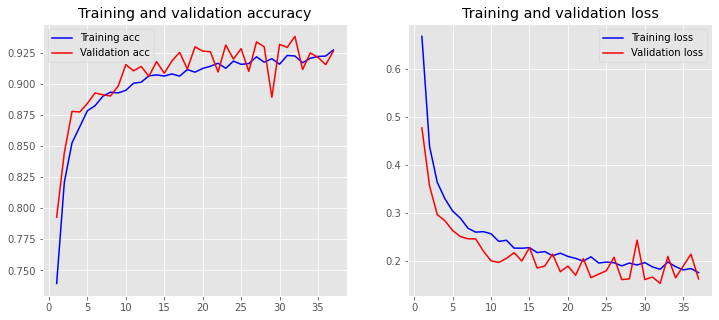

In [30]:
## plot the loss's and accurracy's
plot_history(history_best_model)

In [31]:
score = best_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('-------------------------------')
score = best_model.evaluate(X_val,y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
print('-------------------------------')
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.13607995212078094
Train accuracy: 0.9429653286933899
-------------------------------
Validation loss: 0.15276652574539185
Validation accuracy: 0.9381800293922424
-------------------------------
Test loss: 0.13039684295654297
Test accuracy: 0.9444191455841064


In [ ]:
## V- SA

In [34]:
### save the history and the models for further use and investigations

save_path = "./"
import pickle
import os

# save:
f = open(os.path.join(save_path,"history_house_prices_vf.pckl"), 'wb')
pickle.dump(history_best_model.history, f)
f.close()

# save entire network to HDF5 (save everything, suggested)
best_model.save(os.path.join(save_path,"network_house_prices_vf.h5"))